### Historical temperature, precipitation, and extreme weather events from Nepal Department of Hydrology and Meteorology

In [44]:
import pandas as pd


In [45]:
df_precipitation = pd.read_csv('../data/Weather_&_Climate/preliminary-monthly-weather-data-2018.csv')
df_precipitation.head()

,Date,Parameters,Dadeldhura,Darchula,Dhangadhi,Dipayal,Jumla,Surkhet,Nepalgunj Airport,Chaurjharitar,...,Dhankuta,Dharan,Biratnagar Airport,Tarahara,Khadbari,Taplejung,Kankai,Taulihawa,Godawari,Udaypurgadhi
0,2018-01,Total Precipitation(mm),12.7,21.8,7,2,5,7.5,6,-,...,0,0,0,0,0,1,0,-,-,-
1,2018-01,% of Normal Precipitation,29.7,47,24.6,5.2,17.6,21.8,20.5,-,...,0,0,0,0,0,9,0,-,-,-
2,2018-01,No. of Rainy Days (≥1.0mm),1,1,1,1,1,2,1,-,...,0,0,0,0,0,1,0,-,-,-
3,2018-01,No. of Rainy Days (≥10.0mm),1,1,0,0,0,0,0,-,...,0,0,0,0,0,0,0,-,-,-
4,2018-01,No .of Rainy Days (≥25.0mm),0,0,0,0,0,0,0,-,...,0,0,0,0,0,0,0,-,-,-


In [46]:
import numpy as np

### Reshape the dataset into tidy format 

In [47]:
df_tidy = df_precipitation.melt(id_vars=["Date", "Parameters"], 
                                 var_name="Station", 
                                 value_name="Value")


#### Clean and parse values

In [48]:
# Replace missing or dash entries with NaN
df_tidy['Value'] = df_tidy['Value'].replace(['-', 'NA', 'N/A', ''], np.nan)


In [49]:
# Extract only the first valid numeric part (e.g., from '21.6/19')
df_tidy['Value'] = df_tidy['Value'].astype(str).str.extract(r"([-+]?\d*\.?\d+)")


In [50]:
# Convert to float
df_tidy['Value'] = pd.to_numeric(df_tidy['Value'], errors='coerce')

#### Impute missing values

In [51]:
df_tidy['Value'] = df_tidy.groupby('Parameters')['Value'].transform(lambda x: x.fillna(x.mean()))


### Normalization and unit conversion

In [52]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Step 1: Copy original to keep both raw and normalized
df_normalized = df_tidy.copy()

In [53]:
# Step 2: Normalize per 'Parameters' group
# Option 1: Min-Max Scaling [0, 1]
scaler = MinMaxScaler()

In [54]:
df_normalized['Value_norm'] = df_normalized.groupby('Parameters')['Value'] \
    .transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())


In [55]:
# Step 3: Inspect result
print(df_normalized.head())

      Date                   Parameters     Station  Value  Value_norm
0  2018-01      Total Precipitation(mm)  Dadeldhura   12.7    0.008815
1  2018-01    % of Normal Precipitation  Dadeldhura   29.7    0.062605
2  2018-01   No. of Rainy Days (≥1.0mm)  Dadeldhura    1.0    0.033333
3  2018-01  No. of Rainy Days (≥10.0mm)  Dadeldhura    1.0    0.035714
4  2018-01  No .of Rainy Days (≥25.0mm)  Dadeldhura    0.0    0.000000


### Visualize Normalized vs Original Data

/tmp/ipykernel_5934/2987397210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis['Value_norm'] = df_vis.groupby('Station')['Value'].transform(


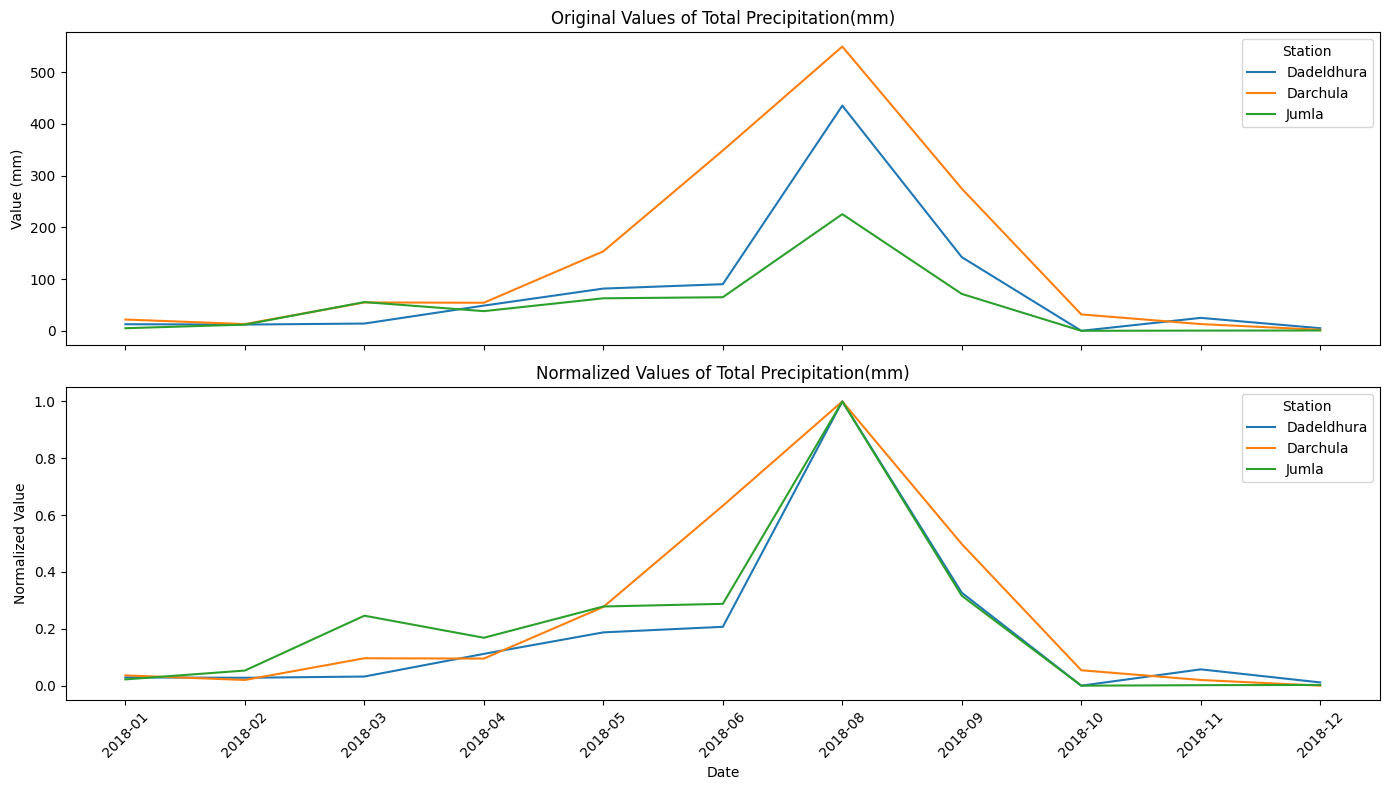

In [56]:

import matplotlib.pyplot as plt
import seaborn as sns

# Filter one parameter for clarity
param_to_plot = "Total Precipitation(mm)"
df_vis = df_tidy[df_tidy["Parameters"] == param_to_plot]

# Add normalized values manually (if not done earlier)
df_vis['Value_norm'] = df_vis.groupby('Station')['Value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Plot original vs normalized for selected stations
stations_to_plot = ['Dadeldhura', 'Darchula', 'Jumla']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# Original
sns.lineplot(data=df_vis[df_vis['Station'].isin(stations_to_plot)], 
             x='Date', y='Value', hue='Station', ax=axes[0])
axes[0].set_title(f"Original Values of {param_to_plot}")
axes[0].set_ylabel('Value (mm)')

# Normalized
sns.lineplot(data=df_vis[df_vis['Station'].isin(stations_to_plot)], 
             x='Date', y='Value_norm', hue='Station', ax=axes[1])
axes[1].set_title(f"Normalized Values of {param_to_plot}")
axes[1].set_ylabel('Normalized Value')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Temporal Alignment for Time-Series

In [57]:
# Ensure date is in datetime format
df_tidy["Date"] = pd.to_datetime(df_tidy["Date"], format='%Y-%m')

# Pivot the dataset to get each parameter as a separate column
df_aligned = df_tidy.pivot_table(
    index=["Date", "Station"],
    columns="Parameters",
    values="Value"
).reset_index()

# Sort for time-based analysis
df_aligned.sort_values(by=["Station", "Date"], inplace=True)

# View aligned dataset
df_aligned.head()


Parameters,Date,Station,% of Normal Precipitation,24 Hours Extreme Rainfall and Date,Average Max Temperature(°C),Average Maximum Temperature(°C),Average Min Temperature(°C),Departure from the Normal Mean Temperature,Departure from the Normal Temperature(°C),Departure from the normal Mean Temperature,...,No. of Days with Maximum Temperature <0(°C),No. of Days with Maximum Temperature >30(°C),No. of Days with Minimum Temperature <0(°C),No. of Days with Minimum Temperature >30(°C),No. of Days with minimum temperature >30(°C),No. of Rainy Days (≥1.0mm),No. of Rainy Days (≥10.0mm),No. of Rainy Days (≥25.0mm),No. of Rainy Days (≥50.0mm),Total Precipitation(mm)
0,2018-01-01,Bhairhawa Airport,33.9,6.0,15.5,NaN,7.3,-3.5,-5.5,NaN,...,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,6.0
38,2018-02-01,Bhairhawa Airport,15.6,3.0,25.9,NaN,10.2,0.0,0.5,NaN,...,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,3.0
76,2018-03-01,Bhairhawa Airport,47.9,8.0,32.8,NaN,14.8,0.8,1.4,NaN,...,NaN,30.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,8.0
114,2018-04-01,Bhairhawa Airport,207.8,22.0,NaN,35.3,20.2,NaN,-0.8,-0.2,...,NaN,NaN,NaN,NaN,30.0,5.0,2.0,0.0,0.0,54.9
152,2018-05-01,Bhairhawa Airport,177.6,65.0,34.9,NaN,22.3,-1.4,-1.5,NaN,...,NaN,31.0,NaN,NaN,NaN,8.0,4.0,2.0,1.0,146.1


In [58]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd

### load the municipalities GeoJSON

In [61]:
import geopandas as gpd

# Step 0: Load the GeoDataFrame
gdf = gpd.read_file("../data/nepal-municipalities.geojson")

# Step 1: Project to UTM Zone 44N (EPSG:32644) for Nepal
gdf_projected = gdf.to_crs(epsg=32644)

# Step 2: Calculate centroids in UTM projection
gdf_projected['centroid'] = gdf_projected.geometry.centroid

# Step 3: Reproject centroids back to WGS84 (EPSG:4326)
gdf_centroids = gpd.GeoSeries(gdf_projected['centroid'], crs=32644).to_crs(epsg=4326)

# Step 4: Extract Longitude and Latitude
gdf['Longitude'] = gdf_centroids.x
gdf['Latitude'] = gdf_centroids.y

# Quick Check
print(gdf[['NAME', 'Longitude', 'Latitude']].head())


AttributeError: module 'fiona' has no attribute 'path'

In [ ]:
import geopandas as gpd
import pandas as pd

# Settings
param_to_map = "Total Precipitation(mm)"
month_to_map = '2018-07-01'

# Step 1: Filter data for the selected month and parameter
df_filtered = df_aligned[df_aligned['Date'] == month_to_map][['Station', param_to_map]]
df_filtered['Station_lower'] = df_filtered['Station'].str.lower()

# Step 2: Prepare gdf for matching
gdf['NAME_lower'] = gdf['NAME'].str.lower()

# Step 3: Merge
gdf_merged = gdf.merge(df_filtered, left_on='NAME_lower', right_on='Station_lower', how='left')

# Step 4: Filter valid rows (with geometry + non-null value)
gdf_valid = gdf_merged[gdf_merged.geometry.notnull() & gdf_merged[param_to_map].notnull()].copy()

#  Step 5: Debug checks
print(f"Total municipalities in GeoData: {len(gdf)}")
print(f"Stations in weather data for {month_to_map}: {df_filtered['Station'].nunique()}")
print(f"Matched rows with valid geometry and {param_to_map}: {len(gdf_valid)}")

# Step 6: Abort if empty
if gdf_valid.empty:
    print(" No valid data found for the selected parameter and month. Check name matching or availability.")
else:
    # Step 7: Plot with fallback center
    map_center = [28.3949, 84.1240]  # Center of Nepal
    gdf_valid.explore(
        column=param_to_map,
        cmap="YlGnBu",
        legend=True,
        tooltip=["NAME", param_to_map],
        popup=True,
        style_kwds={"fillOpacity": 0.7},
        height=600,
        location=map_center
    )


Total municipalities in GeoData: 766
Stations in weather data for 2018-07-01: 0
Matched rows with valid geometry and Total Precipitation(mm): 0
⚠️ No valid data found for the selected parameter and month. Check name matching or availability.


In [ ]:


import pandas as pd
import geopandas as gpd
from rapidfuzz import process

def plot_weather_parameters_on_map(df_aligned, geojson_path, parameters_to_plot, match_threshold=80):
    """
    Plots specified weather parameters on a map by matching station names to municipality polygons.

    Args:
        df_aligned (pd.DataFrame): Weather data with 'Station' and time-series parameter columns.
        geojson_path (str): Path to the Nepal GeoJSON file.
        parameters_to_plot (list): List of parameter names to plot.
        match_threshold (int): Fuzzy match score threshold (default=80).
    """
    # --- Load GeoJSON ---
    gdf = gpd.read_file(geojson_path)
    gdf['NAME_clean'] = gdf['NAME'].str.lower().str.strip()

    # --- Clean and Validate Weather Data ---
    df = df_aligned.copy()
    df.columns = df.columns.str.strip()
    df['Station_clean'] = df['Station'].str.lower().str.strip()

    # --- Fuzzy Match Station ↔ Municipality ---
    station_list = df['Station_clean'].dropna().unique()
    municipality_list = gdf['NAME_clean'].dropna().unique()

    station_to_name = {
        station: (match := process.extractOne(station, municipality_list))[0] if match[1] >= match_threshold else None
        for station in station_list if (match := process.extractOne(station, municipality_list))
    }

    df['Station_matched'] = df['Station_clean'].map(station_to_name)

    # --- Aggregate by Matched Station ---
    valid_params = [p for p in parameters_to_plot if p in df.columns]
    if not valid_params:
        print("❌ None of the specified parameters exist in the dataset.")
        return

    df_mean = df.groupby("Station_matched")[valid_params].mean().reset_index()

    # --- Merge into GeoDataFrame ---
    gdf_merged = gdf.merge(df_mean, left_on='NAME_clean', right_on='Station_matched', how='left')

    # --- Define Color Maps ---
    default_color_maps = {
        "% of Normal Precipitation": "YlGnBu",
        "24 Hours Extreme Rainfall": "PuBu",
        "Average Max Temperature(°C)": "OrRd",
        "Total Precipitation(mm)": "GnBu"
    }

    # --- Plot Each Parameter ---
    for param in valid_params:
        gdf_valid = gdf_merged[gdf_merged[param].notna() & gdf_merged.geometry.notna()].copy()

        if gdf_valid.empty:
            print(f"⚠️ No valid data to plot for: {param}")
            continue

        print(f"🗺️ Plotting: {param}")
        gdf_valid.explore(
            column=param,
            cmap=default_color_maps.get(param, "YlGnBu"),
            legend=True,
            tooltip=["NAME", param],
            popup=True,
            style_kwds={"fillOpacity": 0.7},
            height=600,
            location=[28.3949, 84.1240]
        )





In [ ]:
plot_weather_parameters_on_map(
    df_aligned=df_aligned,
    geojson_path="../data/nepal-municipalities.geojson",
    parameters_to_plot=[
        "% of Normal Precipitation",
        "24 Hours Extreme Rainfall",
        "Average Max Temperature(°C)",
        "Total Precipitation(mm)"
    ]
)
gdf_ready.explore(
    column="% of Normal Precipitation",
    cmap="YlGnBu",
    legend=True,
    tooltip=["NAME", "% of Normal Precipitation"],
    popup=True,
    style_kwds={"fillOpacity": 0.7},
    height=600,
    location=[28.3949, 84.1240]
)


🗺️ Plotting: % of Normal Precipitation
🗺️ Plotting: Average Max Temperature(°C)
🗺️ Plotting: Total Precipitation(mm)


In [ ]:
# Step 1: Create full date range (based on actual data)
full_dates = pd.date_range(df_aligned['Date'].min(), df_aligned['Date'].max(), freq='MS')  # 'MS' = Month Start

# Step 2: Get all unique stations
stations = df_aligned['Station'].unique()

# Step 3: Create a complete grid of Station × Date
full_index = pd.MultiIndex.from_product([stations, full_dates], names=['Station', 'Date'])
df_full = pd.DataFrame(index=full_index).reset_index()


In [ ]:
# Merge with original data (after selecting key columns)
df_merged = df_full.merge(df_aligned, on=['Station', 'Date'], how='left')


In [ ]:
# Optional forward/backward fill within each station group
df_aligned_filled = df_merged.sort_values(['Station', 'Date']).groupby('Station').ffill().bfill()


In [ ]:
df_aligned_filled.to_csv("../data/Weather_&_Climate/processed/temporally_aligned_weather_data.csv", index=False)


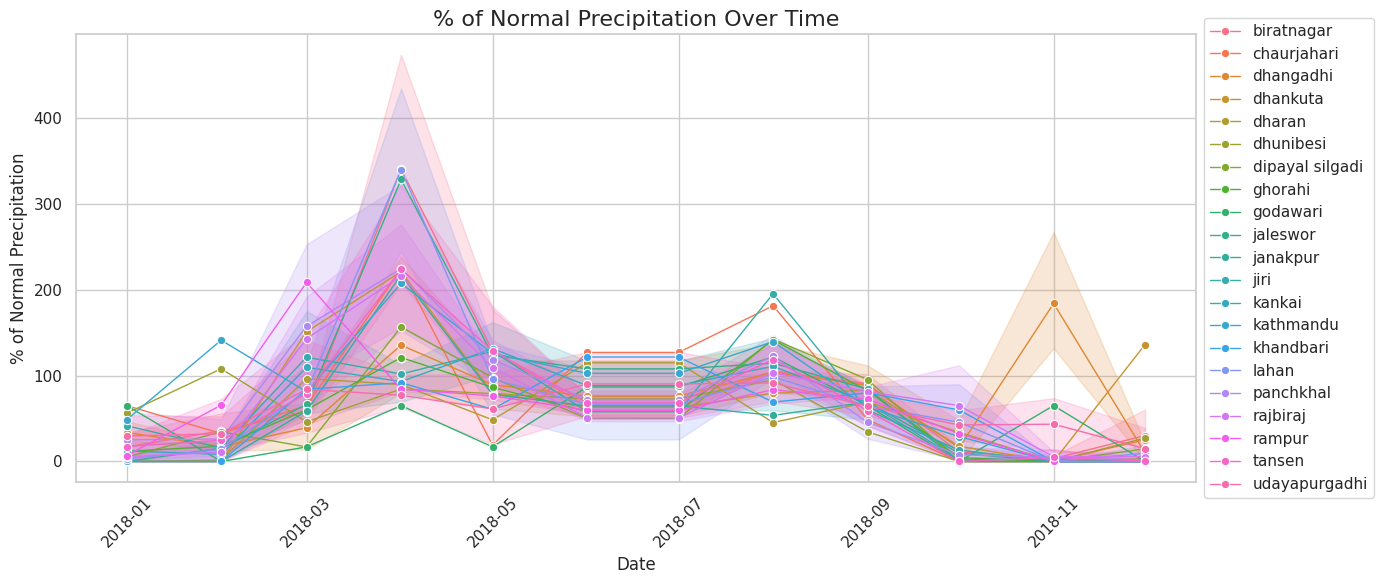

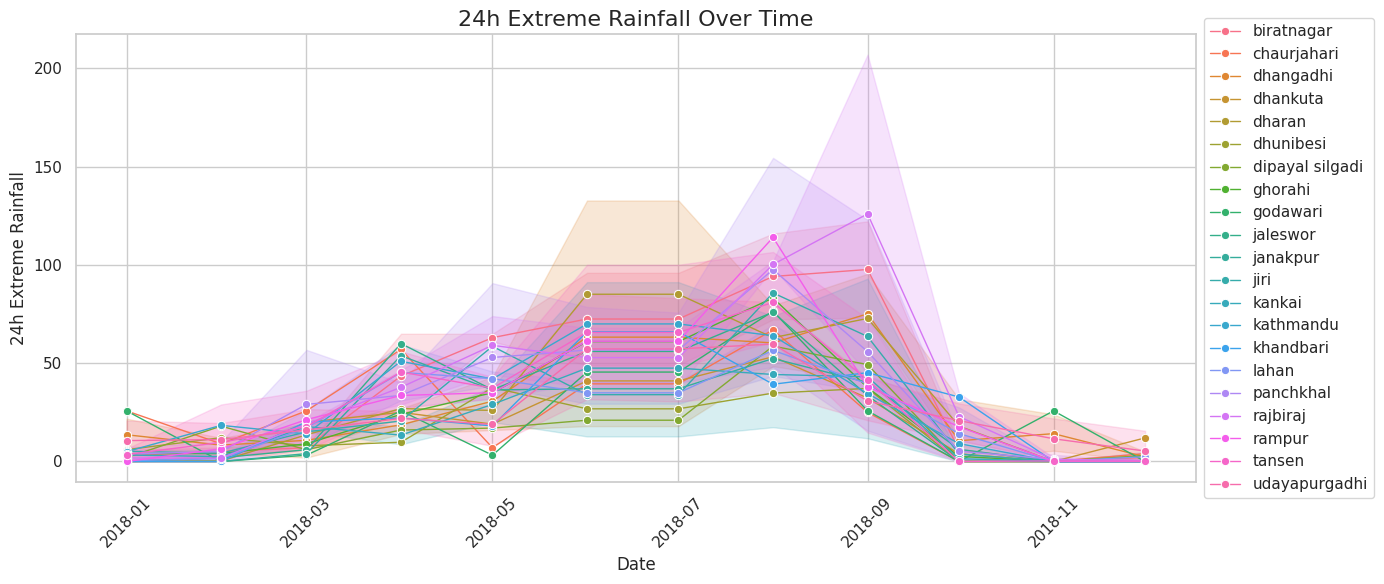

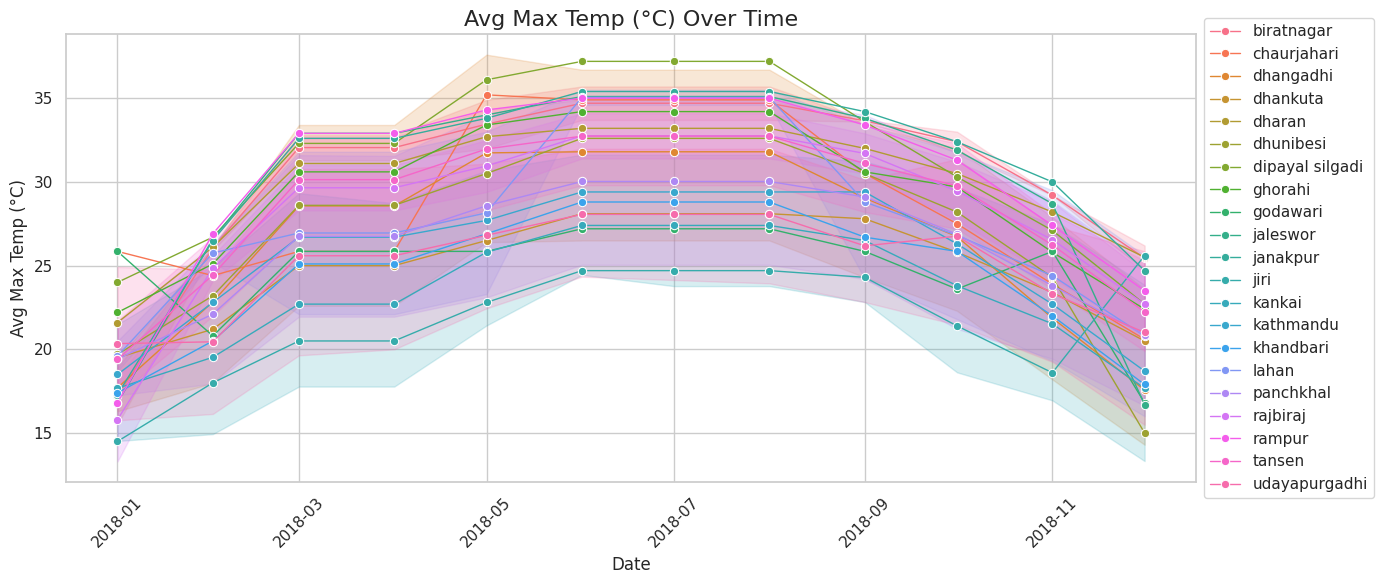

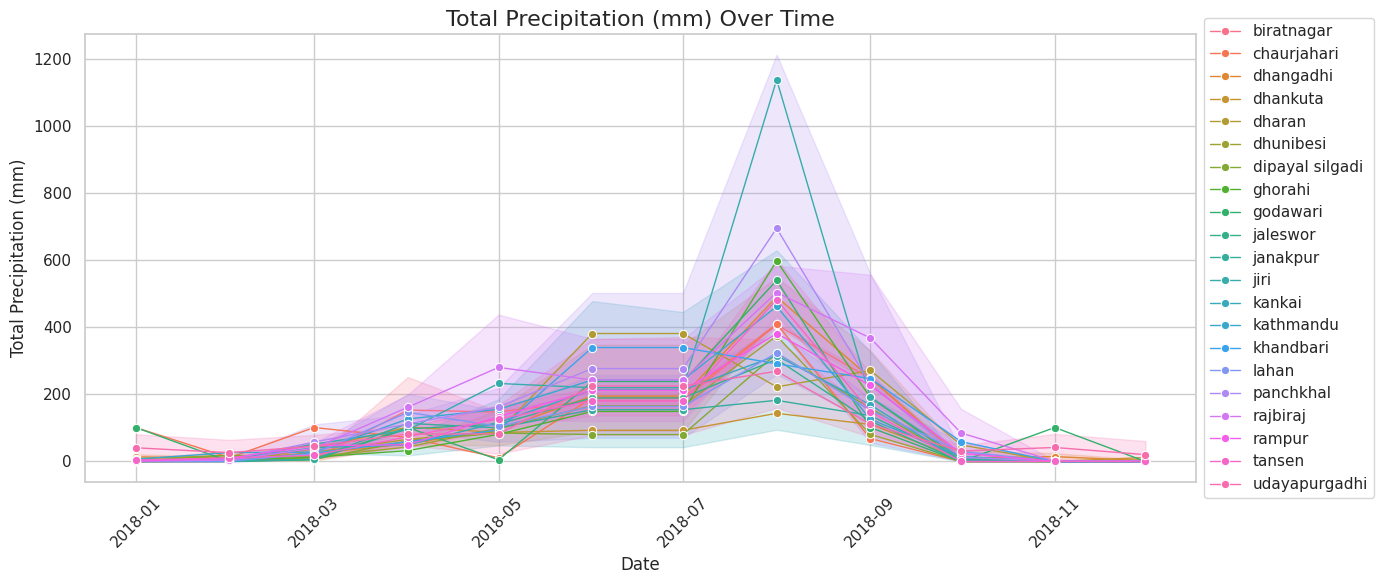

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors 

# Load and clean
df = pd.read_csv("../data/Weather_&_Climate/processed/temporally_aligned_weather_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Station field
station_col = 'station_matched' if 'station_matched' in df.columns else 'station_clean'
df = df[df[station_col].notna() & df['date'].notna()]

# Parameters and labels
parameters_to_plot = [
    "%_of_normal_precipitation",
    "24_hours_extreme_rainfall_and_date",
    "average_max_temperature(°c)",
    "total_precipitation(mm)"
]
pretty_names = {
    "%_of_normal_precipitation": "% of Normal Precipitation",
    "24_hours_extreme_rainfall_and_date": "24h Extreme Rainfall",
    "average_max_temperature(°c)": "Avg Max Temp (°C)",
    "total_precipitation(mm)": "Total Precipitation (mm)"
}

# Plot with interactivity using mplcursors
sns.set(style="whitegrid")
for param in parameters_to_plot:
    if param in df.columns:
        plt.figure(figsize=(14, 6))
        ax = sns.lineplot(
            data=df,
            x='date',
            y=param,
            hue=station_col,
            marker='o',
            linewidth=1
        )
        plt.title(f"{pretty_names.get(param, param)} Over Time", fontsize=16)
        plt.xlabel("Date")
        plt.ylabel(pretty_names.get(param, param))
        plt.xticks(rotation=45)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()

        # Enable tooltips on hover
        cursor = mplcursors.cursor(ax.lines, hover=True)

        @cursor.connect("add")
        def on_add(sel):
            x = sel.target[0]
            y = sel.target[1]
            station = sel.artist.get_label()
            sel.annotation.set(text=f"{station}\nDate: {pd.to_datetime(x).strftime('%Y-%m-%d')}\nValue: {y:.2f}")

        plt.show()
    else:
        print(f" Skipping: '{param}' — not found in the dataset.")


## Data Lineage & Preprocessing Documentation

### 1. Load and Tidy Weather Data

- Used pandas to load CSV data.

- Transformed wide-format data to long-format using melt().

- Cleaned column names (stripped spaces, normalized case).

- Parsed numeric values from mixed strings like "21.6/19".

- Converted Value to float.

### 2. Handle Missing Values
- Replaced '-', 'NA', 'N/A', and empty strings with np.nan.

- Applied mean imputation per parameter group for missing values.

- Columns with known parameters (e.g. Total Precipitation(mm)) imputed individually.

## 3. Normalize Values
- Used MinMaxScaler from sklearn.preprocessing to scale values to [0, 1].

- Normalization applied per parameter or per station, depending on context.

## 4. Temporal Alignment
- Created complete (Station, Date) grid from minimum to maximum observed date.

- Merged original data onto this grid to ensure uniform monthly coverage.

- Applied forward-fill and backward-fill within station groups to fill missing records.

## 5. Georeferencing Stations
- Cleaned station names using lowercase + strip.

- Fuzzy matched station names to NAME field in GeoJSON using rapidfuzz.

- Computed municipality centroids in WGS84 and added Latitude / Longitude to dataset.

## 6. Spatial Join and Merging
- Aggregated parameters (e.g., monthly average precipitation) per matched station.

- Merged into GeoDataFrame (gdf) using matched names (Station_clean ↔ NAME_clean).

- Ensured geometry column carried forward for spatial plotting.

## 7. Plotting & Mapping
- Used GeoPandas.explore() and folium to generate:

- Thematic maps for % of Normal Precipitation, temperature, and rainfall

- Interactive popups, tooltips, and legends

- Color maps: YlGnBu (precipitation), OrRd (temperature), PuBu (extreme rainfall)

## 8. Exported Dataset
- Final dataset stored as temporally_aligned_weather_data.csv

- Columns: Station, Date, % of Normal Precipitation, 24h Extreme Rainfall, etc.

- Georeferenced using centroid lat/lon.

- Also saved as GeoJSON for use in QGIS or web mapping apps.

# Exploratory Data Analysis (EDA)

## 1. Temperature Trends by Region

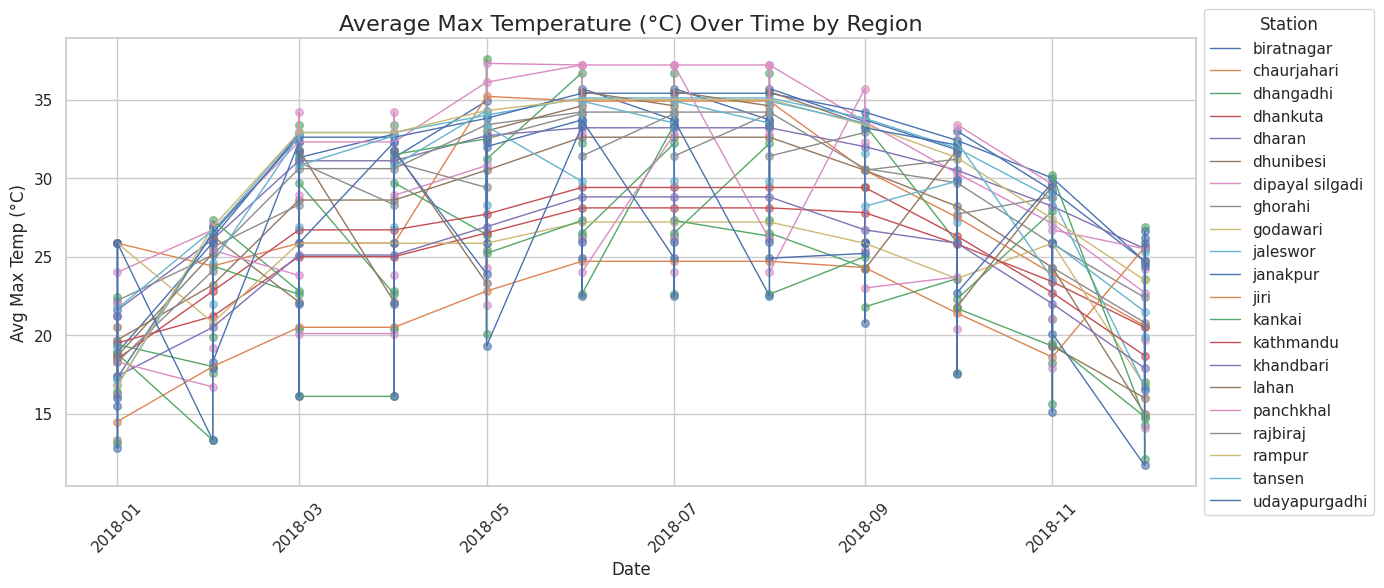

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors

# Step 1: Load and clean the dataset
df = pd.read_csv("../data/Weather_&_Climate/processed/temporally_aligned_weather_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Step 2: Determine station field
station_col = 'station_matched' if 'station_matched' in df.columns else 'station_clean'
df = df[df[station_col].notna() & df['date'].notna()]

# Step 3: Plot temperature trends
param = "average_max_temperature(°c)"
title = "Average Max Temperature (°C) Over Time by Region"

plt.figure(figsize=(14, 6))
scatter_artists = []

for station, group in df.groupby(station_col):
    group = group.sort_values('date')
    plt.plot(group['date'], group[param], label=station, linewidth=1)
    sc = plt.scatter(group['date'], group[param], s=30, alpha=0.6)
    scatter_artists.append(sc)

plt.title(title, fontsize=16)
plt.xlabel("Date")
plt.ylabel("Avg Max Temp (°C)")
plt.xticks(rotation=45)
plt.legend(title="Station", bbox_to_anchor=(1, 0.5), loc="center left")
plt.tight_layout()

# Step 4: Add interactivity
cursor = mplcursors.cursor(scatter_artists, hover=True)

@cursor.connect("add")
def on_add(sel):
    idx = sel.index
    x, y = sel.artist.get_offsets()[idx]
    for station, group in df.groupby(station_col):
        if x in group['date'].values and y in group[param].values:
            sel.annotation.set_text(
                f"📍 {station}\n📅 {pd.to_datetime(x).strftime('%Y-%m-%d')}\n🌡️ Temp: {y:.2f}°C"
            )
            break

plt.show()


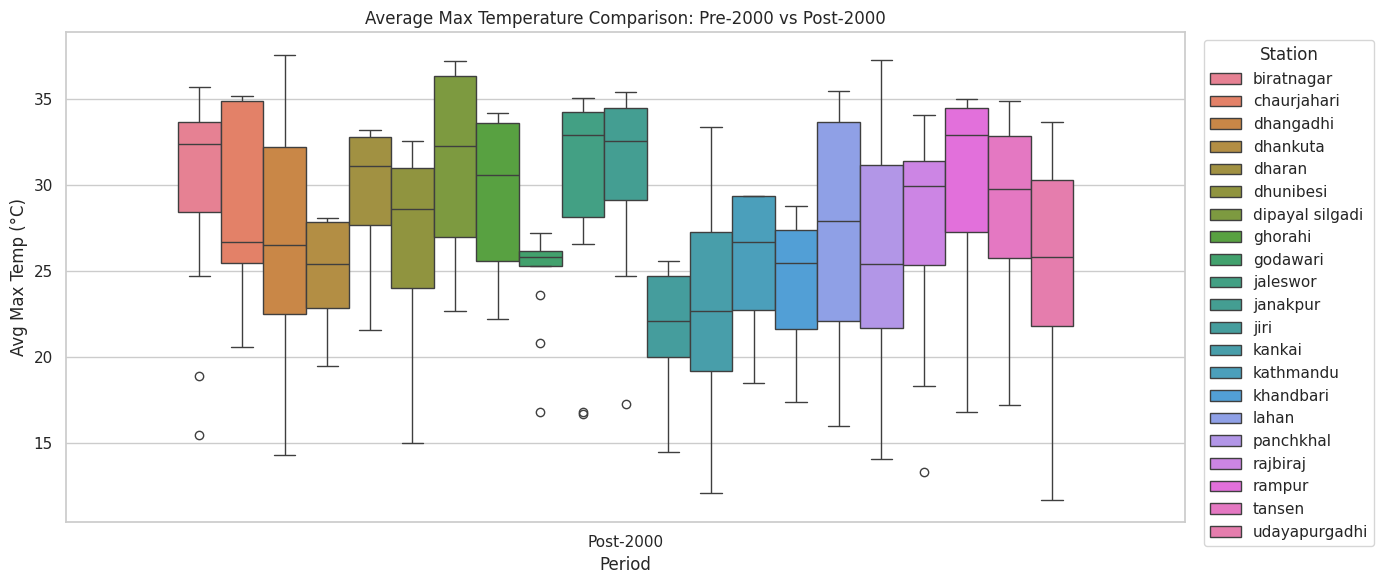

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean
df = pd.read_csv("../data/Weather_&_Climate/processed/temporally_aligned_weather_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Use the appropriate station column
station_col = 'station_matched' if 'station_matched' in df.columns else 'station_clean'
df = df[df[station_col].notna() & df['date'].notna()]

# Extract year and time period
df['year'] = df['date'].dt.year
df['period'] = df['year'].apply(lambda x: "Pre-2000" if x < 2000 else "Post-2000")

# Filter to avoid NaNs in temperature
df_temp = df[['average_max_temperature(°c)', 'period', station_col]].dropna()

# Plot: boxplot comparing pre vs post 2000
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_temp, x='period', y='average_max_temperature(°c)', hue=station_col)
plt.title("Average Max Temperature Comparison: Pre-2000 vs Post-2000")
plt.xlabel("Period")
plt.ylabel("Avg Max Temp (°C)")
plt.legend(title="Station", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_5425/4072890996.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




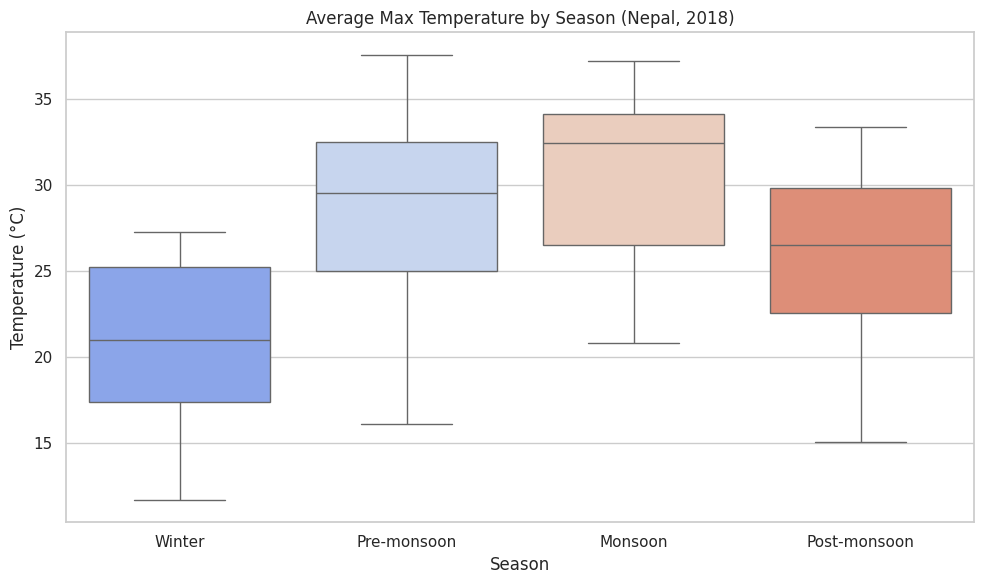

In [ ]:
# Assign season to each date
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Pre-monsoon"
    elif month in [6, 7, 8, 9]:
        return "Monsoon"
    else:
        return "Post-monsoon"

df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(get_season)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='season', y='average_max_temperature(°c)', palette='coolwarm')
plt.title("Average Max Temperature by Season (Nepal, 2018)")
plt.ylabel("Temperature (°C)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()



/tmp/ipykernel_5425/3728638910.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




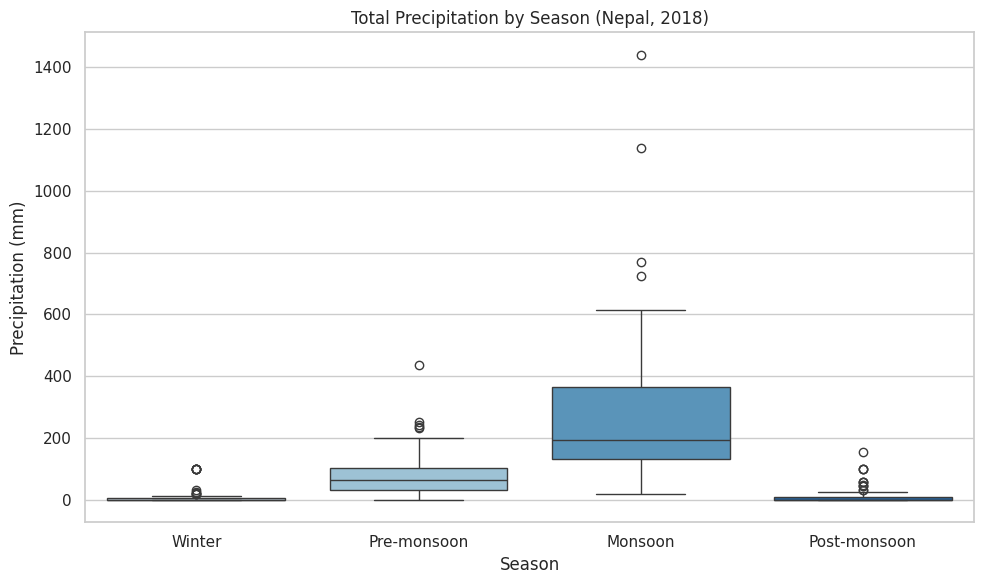

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='season', y='total_precipitation(mm)', palette='Blues')
plt.title("Total Precipitation by Season (Nepal, 2018)")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()


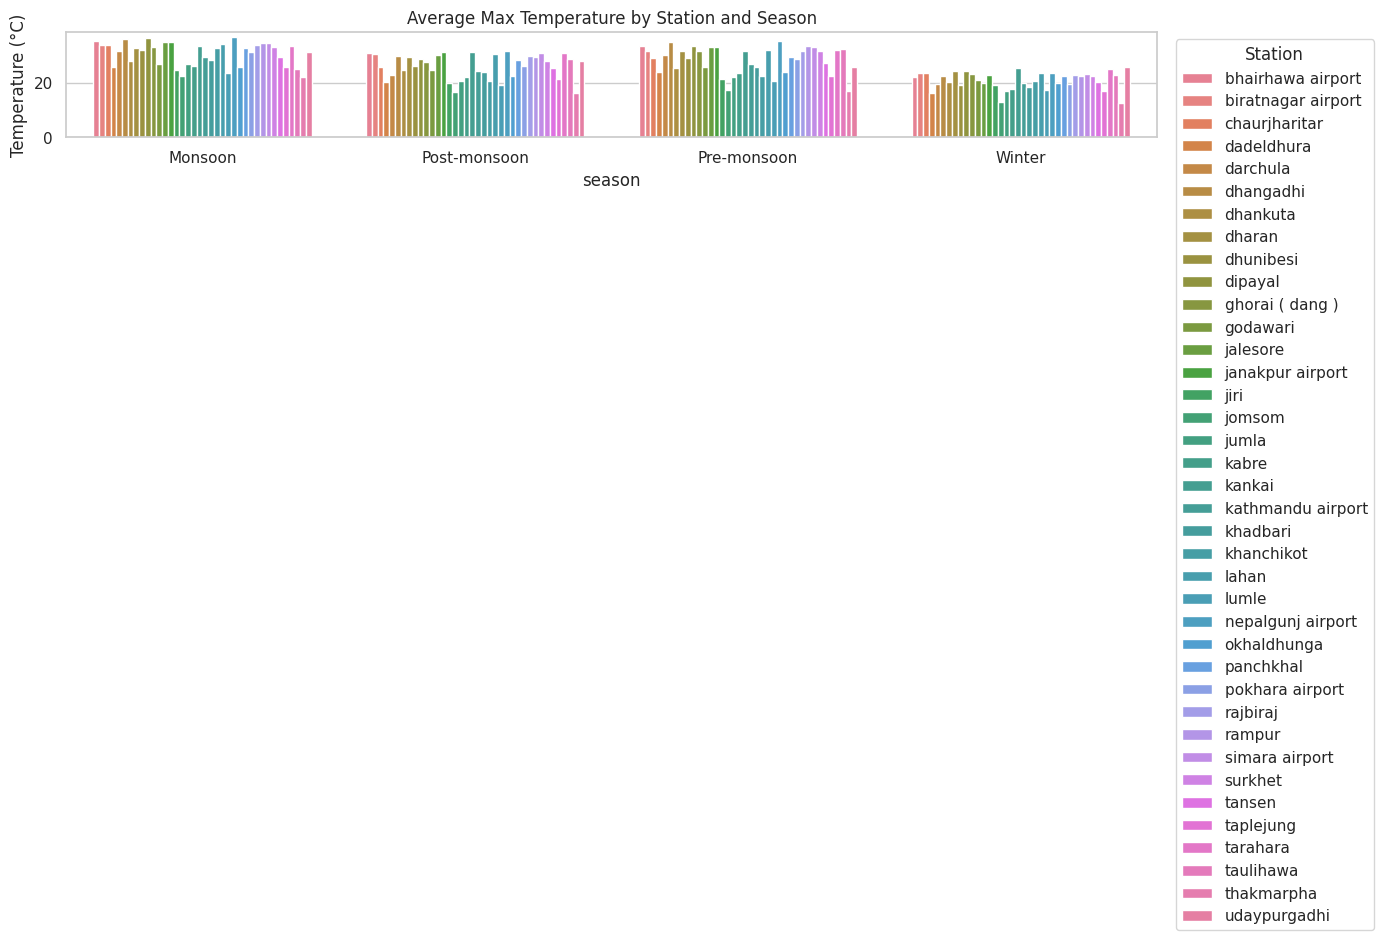

In [ ]:
# Group and average
seasonal_summary = df.groupby(['station_clean', 'season'])[
    ['average_max_temperature(°c)', 'total_precipitation(mm)']
].mean().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=seasonal_summary, x='season', y='average_max_temperature(°c)', hue='station_clean')
plt.title("Average Max Temperature by Station and Season")
plt.ylabel("Temperature (°C)")

# Move legend to the right side (non-overlapping)
plt.legend(title="Station", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()


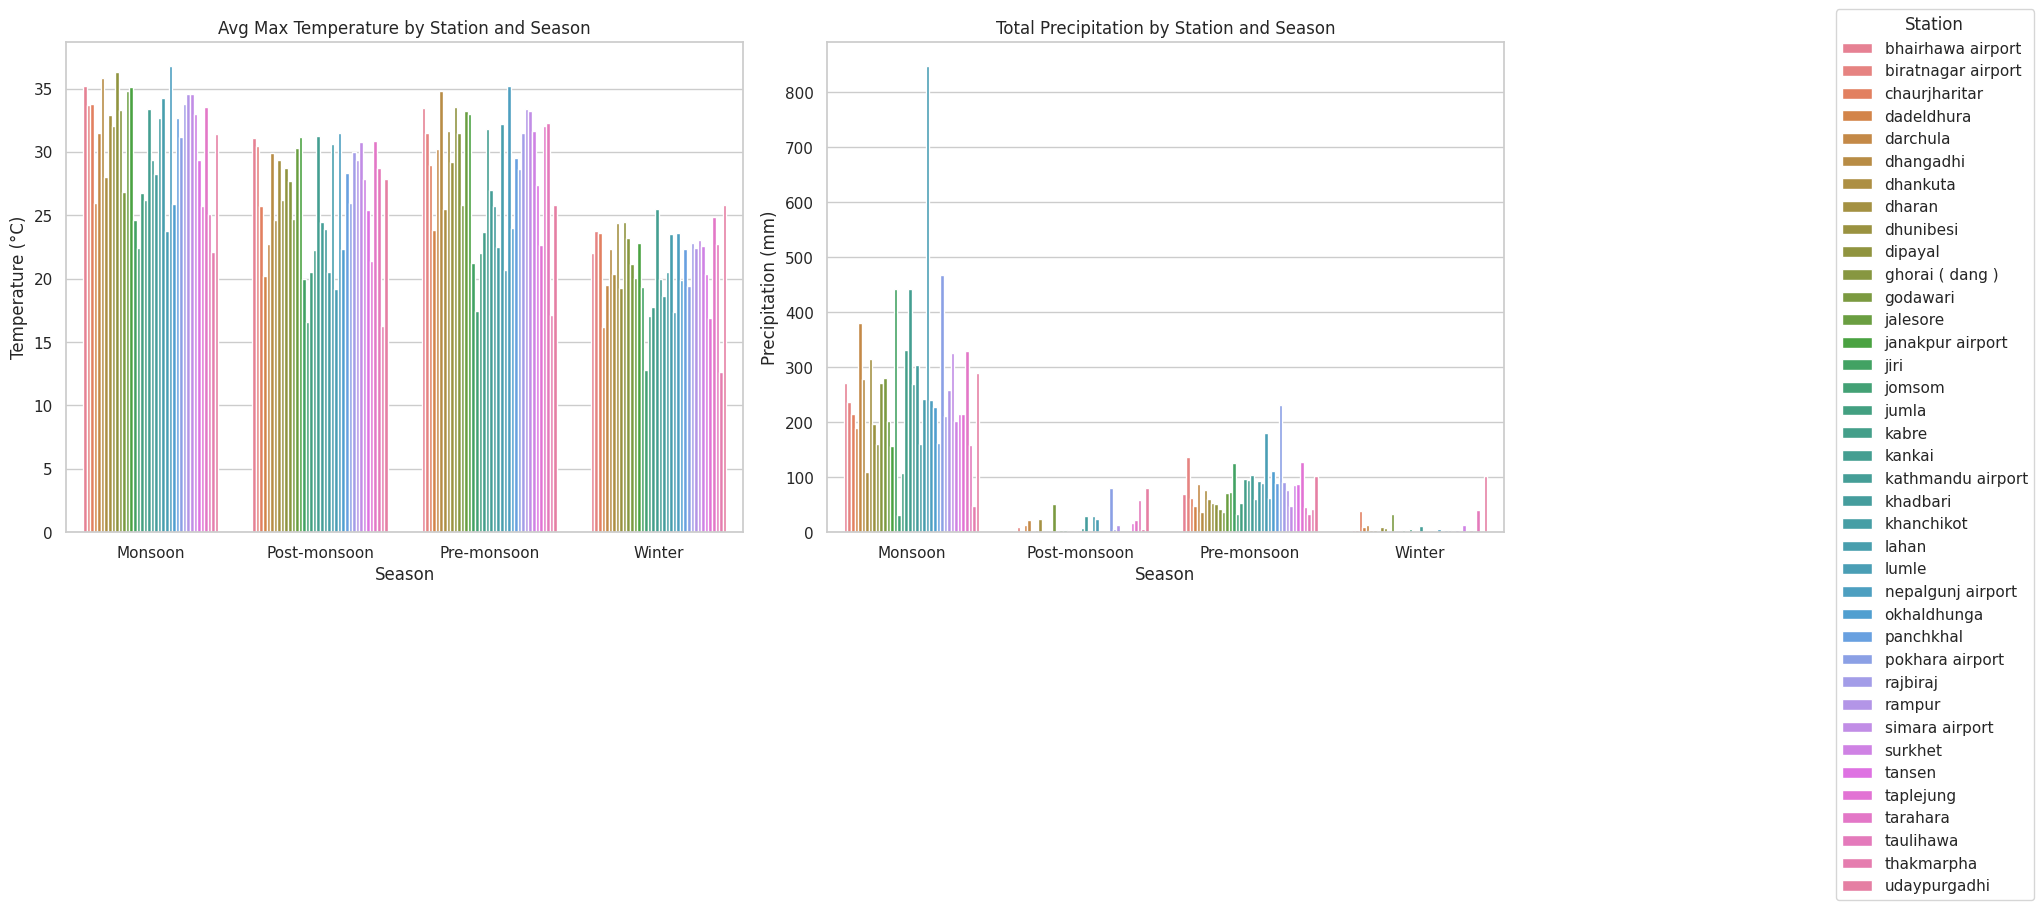

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and average data
seasonal_summary = df.groupby(['station_clean', 'season'])[
    ['average_max_temperature(°c)', 'total_precipitation(mm)']
].mean().reset_index()

# Create 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=False)

# Subplot 1: Temperature
sns.barplot(
    data=seasonal_summary,
    x='season',
    y='average_max_temperature(°c)',
    hue='station_clean',
    ax=axes[0]
)
axes[0].set_title("Avg Max Temperature by Station and Season")
axes[0].set_ylabel("Temperature (°C)")
axes[0].set_xlabel("Season")

# Subplot 2: Precipitation
sns.barplot(
    data=seasonal_summary,
    x='season',
    y='total_precipitation(mm)',
    hue='station_clean',
    ax=axes[1]
)
axes[1].set_title("Total Precipitation by Station and Season")
axes[1].set_ylabel("Precipitation (mm)")
axes[1].set_xlabel("Season")

#  Shared legend outside the plot
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Station", bbox_to_anchor=(1.02, 1), loc='upper left')

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean
df = pd.read_csv("../data/Weather_&_Climate/processed/temporally_aligned_weather_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Select station column
station_col = 'station_matched' if 'station_matched' in df.columns else 'station_clean'
df = df[df[station_col].notna() & df['date'].notna()]


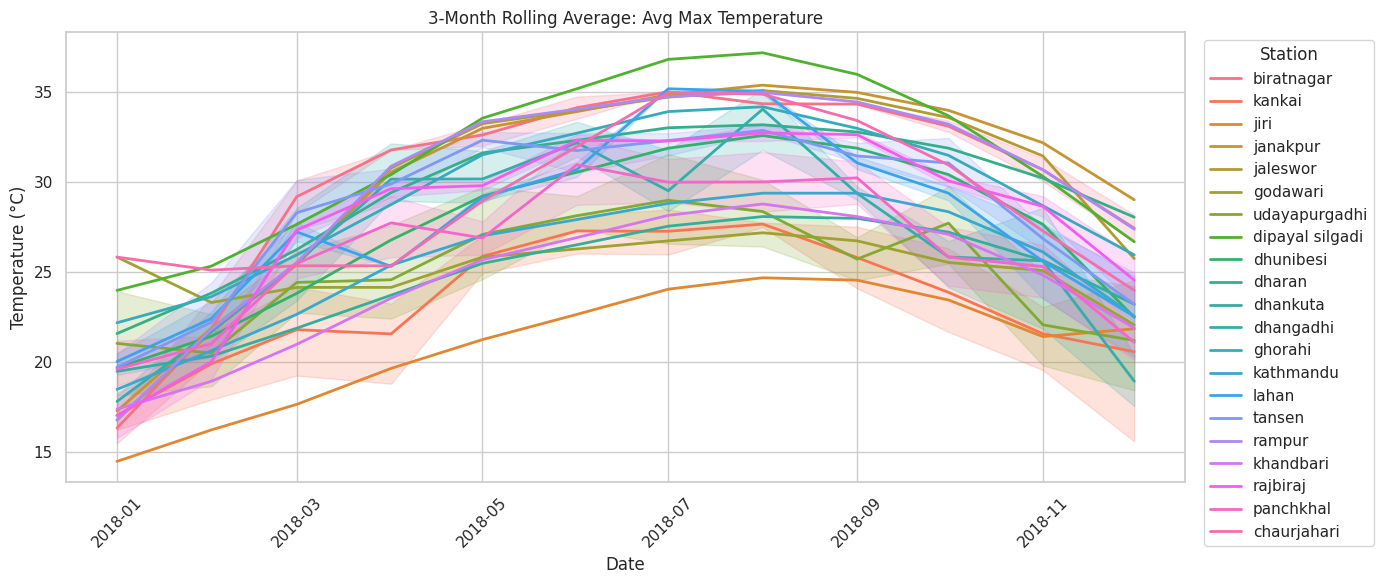

In [ ]:
# Sort and group
df_sorted = df.sort_values('date')
df_sorted['rolling_temp'] = df_sorted.groupby(station_col)['average_max_temperature(°c)'] \
                                     .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_sorted, x='date', y='rolling_temp', hue=station_col, linewidth=2)
plt.title("3-Month Rolling Average: Avg Max Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title='Station', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


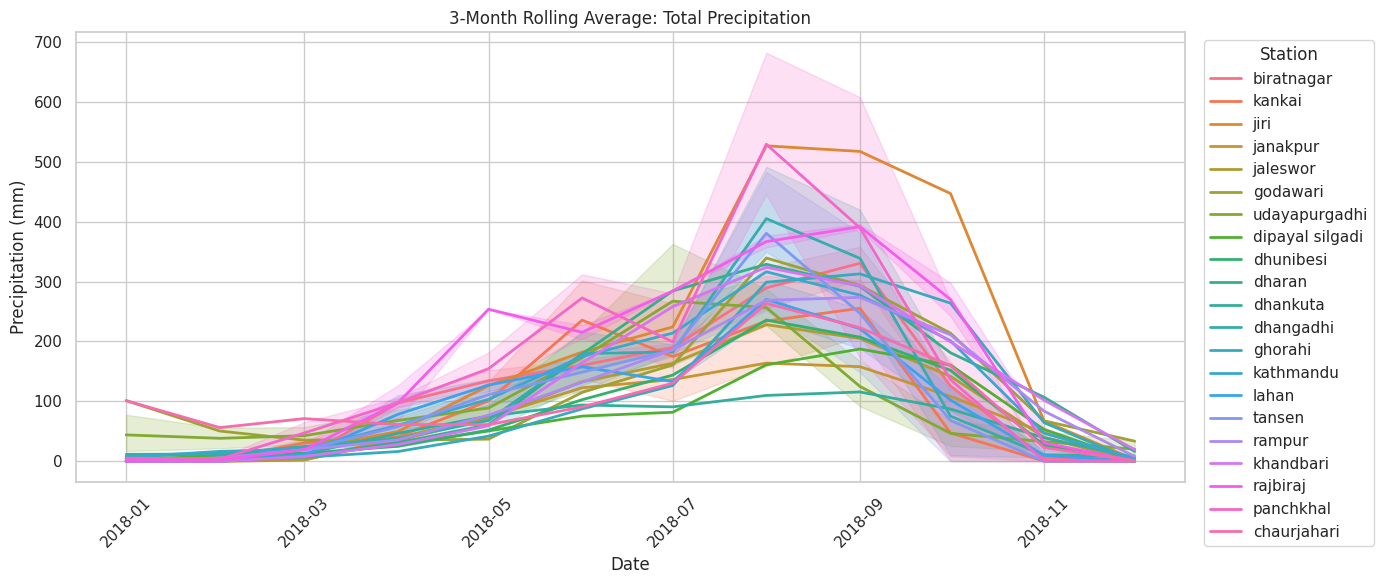

In [ ]:
# Rolling precipitation
df_sorted['rolling_precip'] = df_sorted.groupby(station_col)['total_precipitation(mm)'] \
                                       .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_sorted, x='date', y='rolling_precip', hue=station_col, linewidth=2)
plt.title("3-Month Rolling Average: Total Precipitation")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title='Station', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
